In [1]:
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import skimage.color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import math

Raw Image info: (256, 256, 4)
Raw Image datatype: uint8
(256, 256, 4)
Image shape (numpy array): (256, 256)


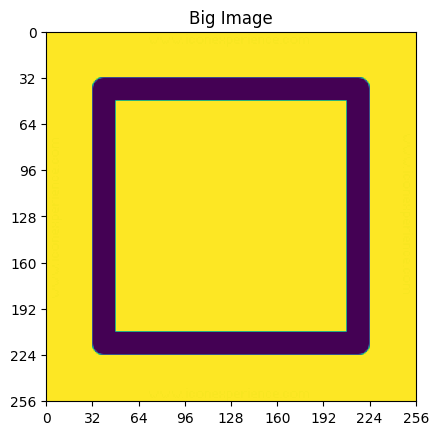

In [2]:
from PIL import Image, ImageOps
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_ip = Image.open("data.png")
#pixels = array(image_ip)
image_raw = np.array(Image.open('data.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)
#print(pixels)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
if len(image_raw.shape) == 2:
    image_raw = skimage.color.gray2rgb(image_raw)
print(image_raw.shape)
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [3]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [4]:
# Initialize some global variable for number of qubits
data_qb = math.ceil(math.log2(image_crop_size**2))
anc_qb = 1
total_qb = data_qb + anc_qb
print('total qbits ' ,total_qb)
# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

total qbits  11


In [5]:
(imageWidth, imageHeight)=image_ip.size

gridx=32
gridy=32
image_splits = []
image_ip_pro = np.array(image_ip)
for h in range(0,imageHeight,gridy):
    for w in range(0,imageWidth,gridx):
        # bbox=(x*gridx, y*gridy, x*gridx+gridx, y*gridy+gridy)
        # slice_bit=image_ip.crop(bbox)
        # slice_bit = np.array(slice_bit)
        slice_bit = image_ip_pro[h:h+gridy, w:w+gridx,0]
        slice_bit = slice_bit / 255
        image_splits.append(slice_bit)
        
# plt.imshow(image_splits[0])
# plt.show()
# plt.imshow(image_splits[1])
# plt.show()

(32, 32)
encoding 0.0007760524749755859
(1024,)
horizontal 0.7311007976531982
vertical 1.435943603515625
running 144.20826506614685
extracting 144.20990562438965


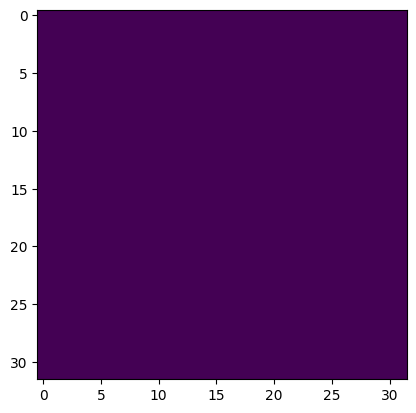

144.34677839279175
(32, 32)
encoding 0.0006000995635986328
(1024,)
horizontal 0.5885050296783447
vertical 1.1858634948730469
running 292.49501490592957
extracting 292.49710845947266


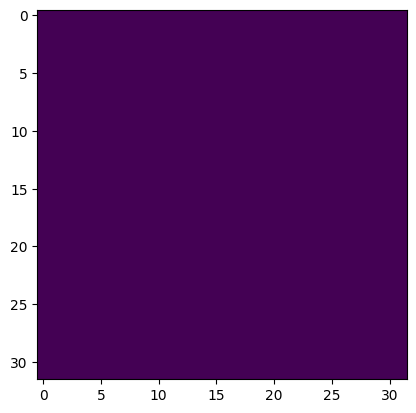

292.62941813468933
(32, 32)
encoding 0.000667572021484375
(1024,)
horizontal 0.8226900100708008
vertical 1.6138217449188232
running 441.564177274704
extracting 441.56613755226135


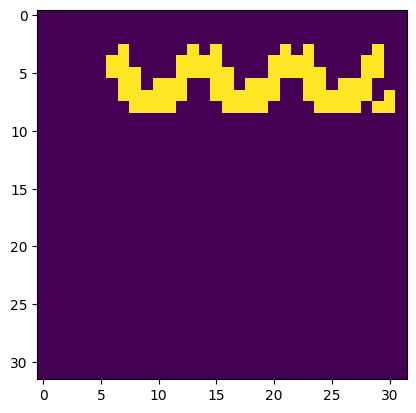

441.69841623306274
(32, 32)
encoding 0.0006420612335205078
(1024,)
horizontal 0.5834693908691406
vertical 1.412827730178833
running 582.2895851135254
extracting 582.2910220623016


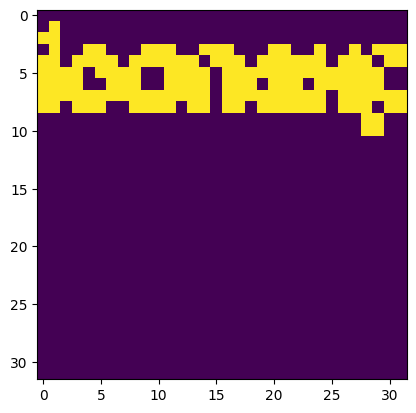

582.426659822464
(32, 32)
encoding 0.0005407333374023438
(1024,)
horizontal 0.7885682582855225
vertical 1.658304214477539
running 737.131618976593
extracting 737.1332285404205


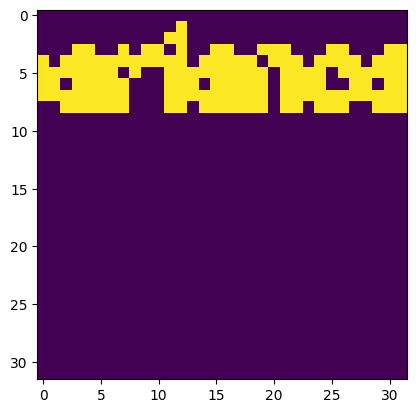

737.4328744411469
(32, 32)
encoding 0.0007634162902832031
(1024,)
horizontal 1.0512843132019043
vertical 1.8754756450653076
running 888.8279981613159
extracting 888.8295588493347


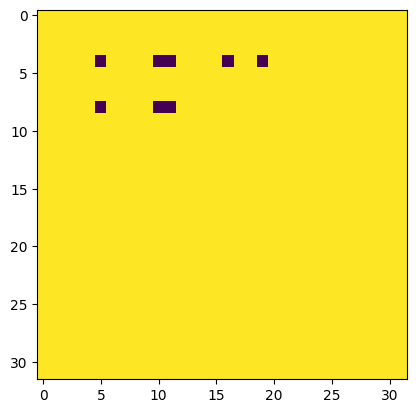

889.009110212326
(32, 32)
encoding 0.0007188320159912109
(1024,)
horizontal 0.7772834300994873
vertical 1.5633196830749512


In [ ]:
import time

def runOnSimulator(back, circuit, qc_h, qc_v):
    results = execute(circuit, backend=back).result()
    sv_h = results.get_statevector(qc_h)
    sv_v = results.get_statevector(qc_v)
    return sv_h,sv_v

threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
back = Aer.get_backend('statevector_simulator')
qc_h = QuantumCircuit(total_qb)
qc_v = QuantumCircuit(total_qb)

edges = []
tot_time = time.time()
for i in range(len(image_splits)):
    start_time = time.time() 
    
    img = image_splits[i]
    print(img.shape)
    image_norm_h = amplitude_encode(img)
    image_norm_v = amplitude_encode(img.T)
    print('encoding', time.time() - start_time)
    print(image_norm_h.shape)
    # horizontal    
    qc_h.initialize(image_norm_h, range(1, total_qb))
    qc_h.h(0)
    qc_h.unitary(D2n_1, range(total_qb))
    qc_h.h(0)
    print('horizontal', time.time() - start_time)
    # display(qc_h.draw('mpl', fold=-1))
    
    # vertical    
    qc_v.initialize(image_norm_v, range(1, total_qb))
    qc_v.h(0)
    qc_v.unitary(D2n_1, range(total_qb))
    qc_v.h(0)
    print('vertical', time.time() - start_time)
    # display(qc_v.draw('mpl', fold=-1))
    # forming the circuit
    circ_list = [qc_h, qc_v]
    
    #running the ciruit 
    sv_h, sv_v = runOnSimulator(back, circ_list, qc_h, qc_v)
    print('running', time.time() - start_time)
    edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(gridy, gridx)
    edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(gridy, gridx).T
    print('extracting', time.time() - start_time)
    edge_scan_sim = edge_scan_h | edge_scan_v
    plt.imshow(edge_scan_sim)
    plt.show()
    edges.append(edge_scan_sim)
    print(time.time() - start_time)
    # plot_image(edge_scan_sim, 'Edge Detected image')
print('total time',time.time() -  tot_time)
